In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
# Quantiles
quantiles = np.linspace(0, 1, 10 + 1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [132]:
# Calculating Breakpoints
breakpoints = np.quantile(ref_data, quantiles)
breakpoints

array([-3.71067945, -1.27514606, -0.90989064, -0.58941863, -0.24005463,
        0.03415724,  0.27468556,  0.54895068,  0.87191766,  1.28684996,
        3.16655683])

In [41]:
# Counting how many samples in each bin
ref_counts = np.histogram(ref_data, breakpoints)[0]
ref_counts

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [158]:
def psi(ref, new, bins=10):

    # Data to array
    ref, new = np.array(ref), np.array(new)

    # Generate 10 equal buckets between 0% and 100%
    quantiles = np.linspace(0, 1, bins + 1)
    breakpoints = np.quantile(ref, quantiles)

    # Counting the number of samples in each bucket
    ref_counts = np.histogram(ref, breakpoints)[0]
    new_counts = np.histogram(new, breakpoints)[0]

    # Calculating the percentage
    ref_pct = ref_counts / len(ref)
    new_pct = new_counts / len(new)

    # If any bucket is zero, add a very small number
    # to prevent division by zero
    ref_pct = np.where(ref_pct == 0, 1e-6, ref_pct)
    new_pct = np.where(new_pct == 0, 1e-6, new_pct)

    # Calculate PSI and return
    return np.sum((ref_pct - new_pct) * np.log(ref_pct / new_pct))

def drift_plot(ref, new):
    fig = plt.hist(ref)
    fig = plt.hist(new, color='r', alpha=.5);

    return plt.show(fig)


# Testing the concept

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# 1. Generate Reference Data
# np.random.seed(42)
X,y = make_regression(n_samples=1000, n_features=3, noise=5, random_state=42)
df = pd.DataFrame(X, columns= ['var1', 'var2', 'var3'])
df['y'] = y

# Separate X and y
X_ref, y_ref = df.drop('y', axis=1), df.y

# View data head
df.head()


,var1,var2,var3,y
0,-0.189120,-1.330314,0.921650,-99.884788
1,-0.653329,-0.474945,1.765454,-58.794289
2,-0.224856,0.076852,-0.650003,-30.448139
3,0.570599,-0.662624,-0.763259,-15.323122
4,0.327880,-0.125454,0.085893,17.961125


In [137]:
# 2. Train Regression Model
model = LinearRegression().fit(X_ref, y_ref)
print(f"Model Trained. Coefficient: {model.coef_[0]:.2f}")

Model Trained. Coefficient: 98.38


In [164]:
# Generate the Drift Data
X,y = make_regression(n_samples=500, n_features=3, noise=5, random_state=42)
df2 = pd.DataFrame(X, columns= ['var1', 'var2', 'var3'])
df2['y'] = y

# Add the drift
df2['var1'] = 5 + 1.5 * X_ref.var1 + np.random.normal(0, 5, 1000)

# Separate X and y
X_new, y_new = df2.drop('y', axis=1), df2.y

# View
df2.head()

,var1,var2,var3,y
0,9.112856,-0.321386,0.412931,-30.017367
1,4.216552,0.302635,-0.754276,-49.461107
2,0.101088,-0.937825,0.515035,-89.433395
3,3.543402,1.530751,1.218762,191.108603
4,7.206087,-1.143005,1.633432,9.868878


PSI Score for Feature var1: 1.3636


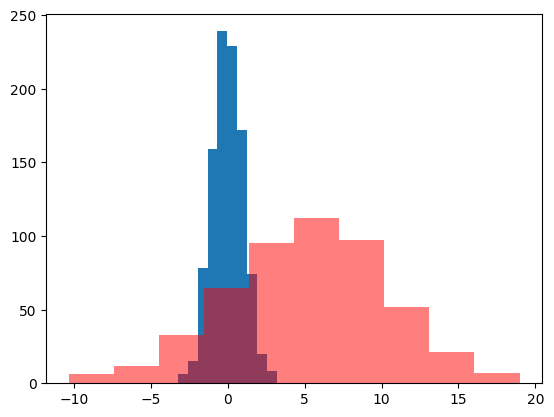



PSI Score for Feature var2: 0.0422


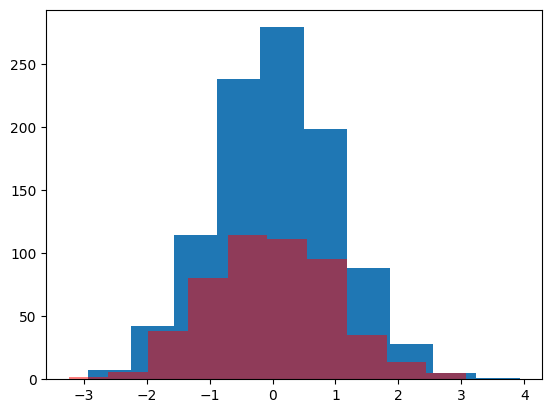



PSI Score for Feature var3: 0.0170


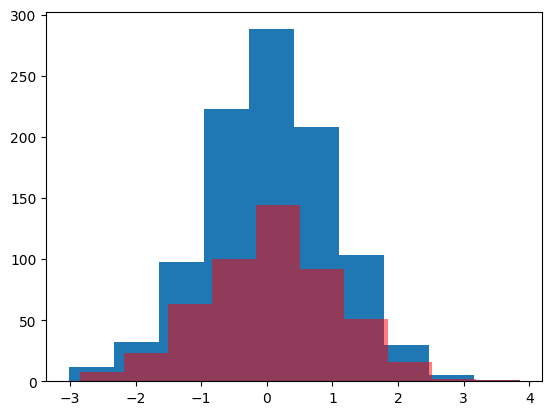

In [171]:
# 4. Calculate PSI for the drifted feature
for v in df.columns[:-1]:
  psi_value= psi(X_ref[v], X_new[v])
  print(f"PSI Score for Feature {v}: {psi_value:.4f}")
  drift_plot(X_ref[v], X_new[v])
  print("\n")

In [166]:
# 5. Generate Estimates to see the impact
preds_ref = model.predict(X_ref[:5])
preds_drift = model.predict(X_new[:5])

print("\nSample Predictions (Reference vs Drifted):")
print(f"Ref Preds: {preds_ref.round(2)}")
print(f"Drift Preds: {preds_drift.round(2)}")


Sample Predictions (Reference vs Drifted):
Ref Preds: [-104.22  -57.58  -32.69  -18.24   24.13]
Drift Preds: [880.75 420.13 -53.91 506.2  657.2 ]
